In [1]:
# Set to 1 to install packages
install <- 0

if( install == 1 ){
    # Install sonification packages
    install.packages(c("BiocManager", "sonify", "BrailleR"))
    # Install microbiome packages
    BiocManager::install(c("mia", "miaViz", "scater"))
    # Install text-to-speech synthesiser
    system2("sudo apt-get install espeak-ng")
}

In [2]:
library(BrailleR)
library(mia)
library(miaViz)
library(scater)
library(sonify)

The BrailleR.View,  option is set to FALSE.


Attaching package: ‘BrailleR’


The following objects are masked from ‘package:graphics’:

    boxplot, hist


The following object is masked from ‘package:utils’:

    history


The following objects are masked from ‘package:base’:

    grep, gsub


Loading required package: MultiAssayExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWei

In [3]:
data("GlobalPatterns", package = "mia")
tse <- GlobalPatterns

tse$SampleType <- gsub("\\)", "", gsub(" \\(", "_", tse$SampleType))

In [3]:
tse <- transformAssay(tse, method = "relabundance")

tse <- agglomerateByPrevalence(
    tse,
    prevalence = 50/100,
    detection = 1/100,
    rank = "Phylum"
)

## Alpha Diversity

This is an untitled chart with no subtitle or caption.
It has x-axis 'SampleType' with labels Feces and Soil.
It has y-axis 'faith_diversity' with labels 6.0, 6.5, 7.0 and 7.5.
There is a legend indicating colour is used to show colour_by, with 2 levels:
Feces shown as light blue colour and 
Soil shown as brilliant orange colour.
It has 2 layers.
Layer 1 is a violin graph that VI cannot process.
Layer 1 has fill set to purplish white.
Layer 1 has colour set to purplish gray.
Layer 1 has alpha set to 0.2.
Layer 2 is a set of 7 big solid circle points of which about 100% can be seen.
The points are at:
(0.82, 6.16) colour light blue which maps to colour_by = Feces, 
(1.2, 6.43) colour light blue which maps to colour_by = Feces, 
(0.78, 6.77) colour light blue which maps to colour_by = Feces, 
(1, 5.72) colour light blue which maps to colour_by = Feces, 
(2.17, 7.89) colour brilliant orange which maps to colour_by = Soil, 
(1.82, 7.76) colour brilliant orange which maps to colour_by = Soi

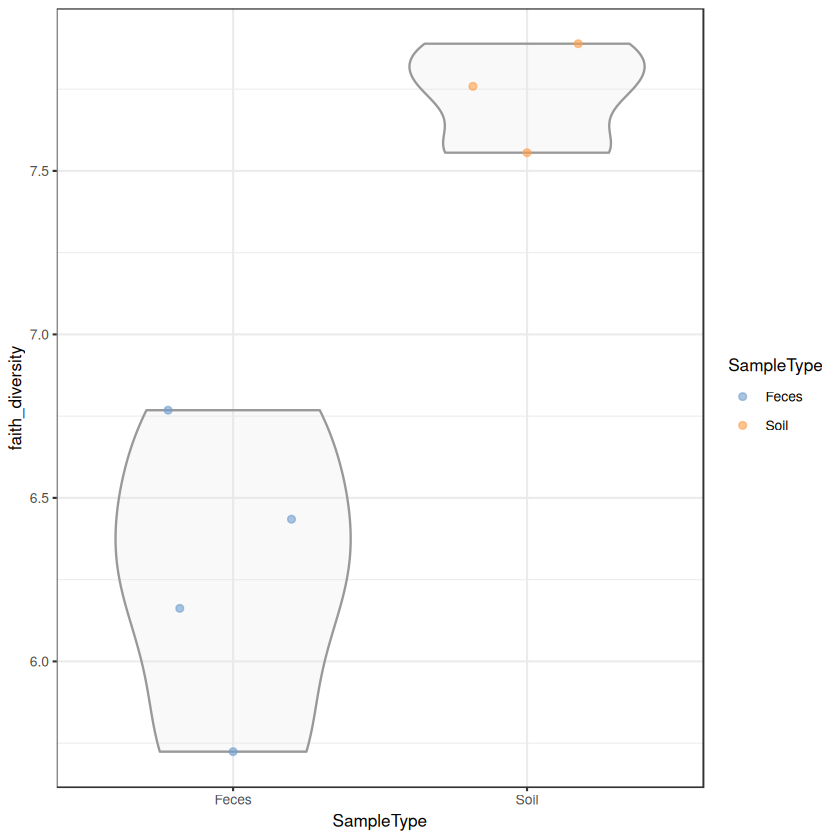

In [4]:
tse <- addAlpha(tse, index = "faith_diversity")

tse_sub <- tse[ , tse$SampleType %in% c("Feces", "Soil")]

plotColData(
    tse_sub,
    y = "faith_diversity",
    x = "SampleType",
    colour_by = "SampleType"
)

## Beta Diversity

This is an untitled chart with no subtitle or caption.
It has x-axis 'MDS 1' with labels 0.0, 0.1 and 0.2.
It has y-axis 'MDS 2' with labels -0.05, 0.00, 0.05 and 0.10.
There is a legend indicating colour is used to show colour_by, with 9 levels:
Feces shown as light blue colour, 
Freshwater shown as brilliant orange colour, 
Freshwater_creek shown as brilliant yellowish green colour, 
Mock shown as strong reddish orange colour, 
Ocean shown as light violet colour, 
Sediment_estuary shown as light reddish brown colour, 
Skin shown as strong purplish pink colour, 
Soil shown as light gray colour and 
Tongue shown as light greenish yellow colour.
The chart is a set of 26 big solid circle points of which about 92% can be seen.
It has alpha set to 0.6.
It has fill set to dark grayish olive green.
It has shape set to big solid circle.

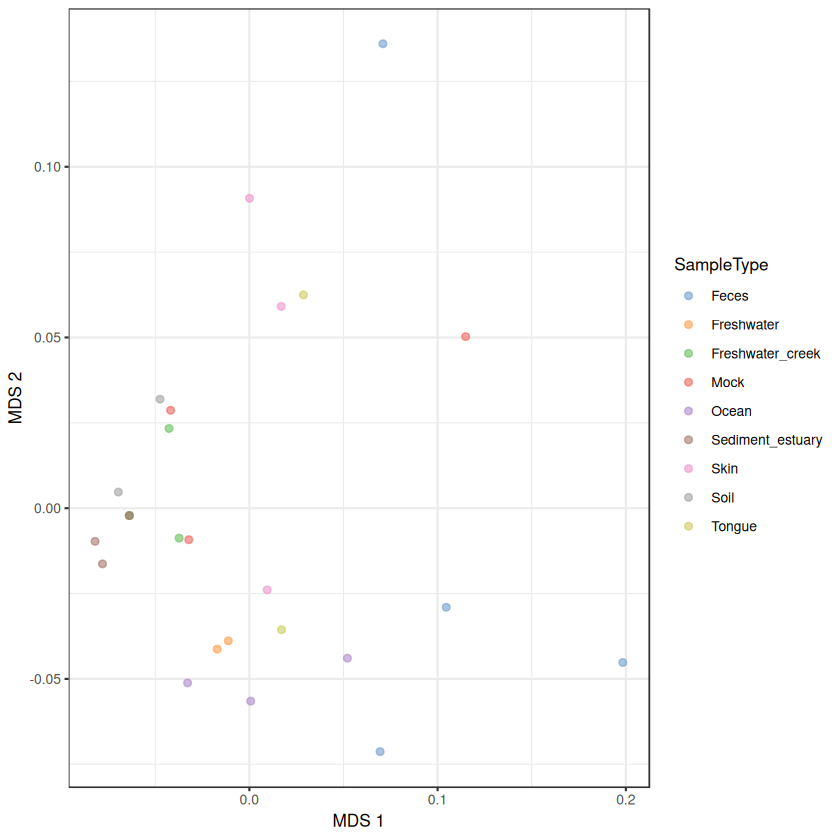

In [5]:
tse <- runMDS(
    tse,
    FUN = getDissimilarity,
    assay.type = "relabundance",
    method = "unifrac",
    tree = rowTree(tse),
    ntop = nrow(tse)
)

plotReducedDim(tse,"MDS", colour_by = "SampleType")

In [7]:
dim_red <- reducedDim(tse, "MDS")

sonify(
    x = dim_red[ , 1], y = dim_red[ , 2],
    waveform = "square", interpolation = "constant",
    pulse_len = 0.1, pulse_amp = 0.5,
    duration = 10, player = "mplayer",
)

## Bacterial Abundance

This is an untitled chart with no subtitle or caption.
It has x-axis 'Samples' with labels Feces, Freshwater, Freshwater_creek, Mock, Ocean, Sediment_estuary, Skin, Soil and Tongue.
It has y-axis 'Abundance' with labels 0e+00, 1e+06, 2e+06, 3e+06, 4e+06 and 5e+06.
There is a legend indicating fill is used to show colour_by, with 6 levels:
Actinobacteria shown as light blue fill, 
Bacteroidetes shown as brilliant orange fill, 
Cyanobacteria shown as brilliant yellowish green fill, 
Firmicutes shown as strong reddish orange fill, 
Other shown as light violet fill and 
Proteobacteria shown as light reddish brown fill.
There is a legend indicating colour is used to show colour_by, with 6 levels:
Actinobacteria shown as light blue colour, 
Bacteroidetes shown as brilliant orange colour, 
Cyanobacteria shown as brilliant yellowish green colour, 
Firmicutes shown as strong reddish orange colour, 
Other shown as light violet colour and 
Proteobacteria shown as light reddish brown colour.
The c

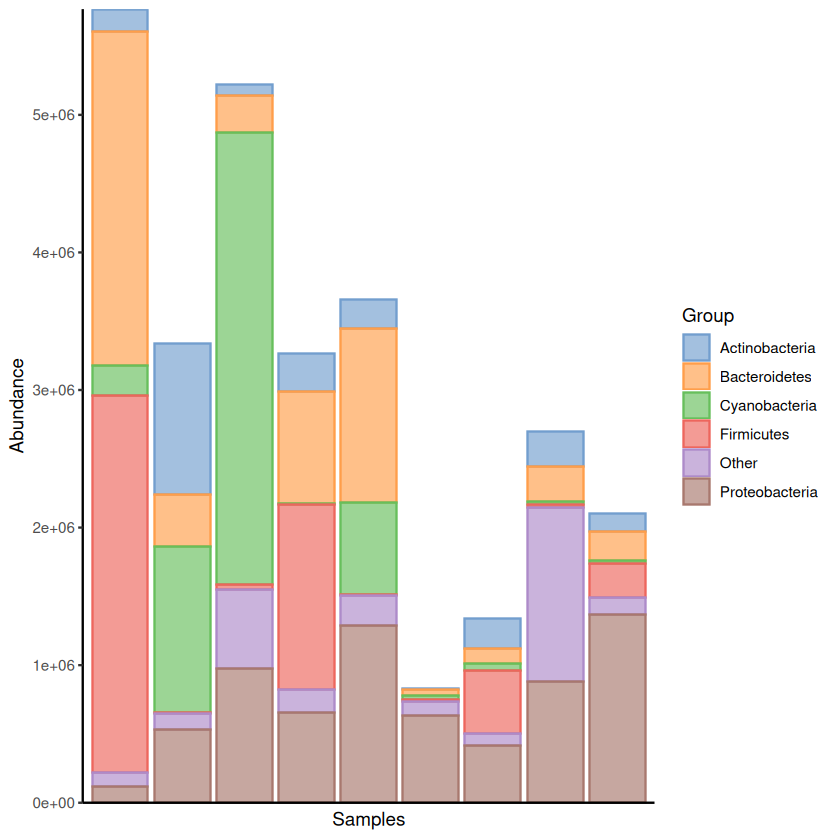

In [8]:
tse <- agglomerateByVariable(
    tse,
    by = 2L,
    group = "SampleType"
)

top_taxa <- getTop(tse)
rowData(tse)$Group <- ifelse(rowData(tse)$Phylum %in% top_taxa,
                             rowData(tse)$Phylum, "Other")

plotAbundance(tse, group = "Group")

In [11]:
abund2freq <- function(abund) {
  
    norm_abund <- (abund - min(abund)) / (max(abund) - min(abund))
    freq <- 440 + norm_abund * (880 - 440)
  
    return(freq)
}

col_sums <- abund2freq(colSums(assay(tse, "counts")))

In [12]:
for( i in seq_along(col_sums) ){
  
    col_sum <- col_sums[i]
    system2("espeak-ng", args = names(col_sum))
  
    sonify(
        y = col_sum,
        waveform = "square",
        interpolation = "constant",
        flim = c(col_sum, col_sum),
        duration = 0.5,
        player = "mplayer",
    )
}

## Bacterial Composition

This is an untitled chart with no subtitle or caption.
It has x-axis 'Samples' with labels Soil.
It has y-axis 'Abundance' with labels 0, 500000, 1000000, 1500000, 2000000 and 2500000.
There is a legend indicating fill is used to show colour_by, with 6 levels:
Actinobacteria shown as light blue fill, 
Bacteroidetes shown as brilliant orange fill, 
Cyanobacteria shown as brilliant yellowish green fill, 
Firmicutes shown as strong reddish orange fill, 
Other shown as light violet fill and 
Proteobacteria shown as light reddish brown fill.
There is a legend indicating colour is used to show colour_by, with 6 levels:
Actinobacteria shown as light blue colour, 
Bacteroidetes shown as brilliant orange colour, 
Cyanobacteria shown as brilliant yellowish green colour, 
Firmicutes shown as strong reddish orange colour, 
Other shown as light violet colour and 
Proteobacteria shown as light reddish brown colour.
The chart is a bar chart with 1 vertical bars.
Bar 1 is centered at 1, and length is 

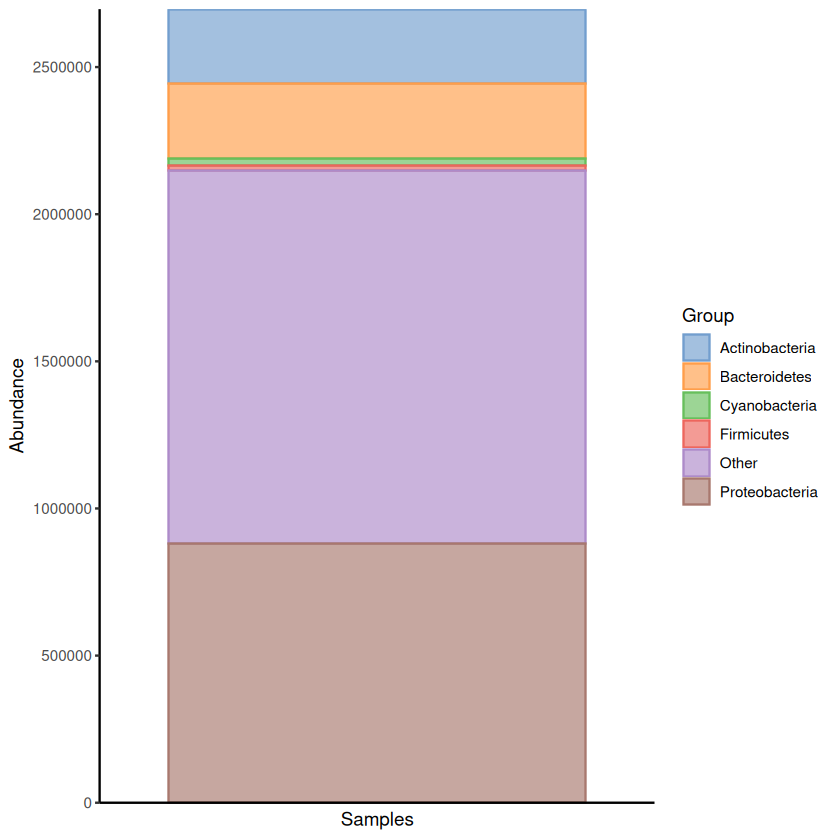

In [15]:
tse_sub <- agglomerateByVariable(
  tse[ , tse$SampleType == "Soil"],
  by = 1L,
  group = "Group"
)

plotAbundance(tse_sub, group = "Group")

In [16]:
soil_sums <- abund2freq(as.vector(assay(tse_sub, "counts")))
names(soil_sums) <- rownames(tse_sub)

for( i in seq_along(soil_sums) ){
    
    soil_sum <- soil_sums[i]
  
    system2("espeak-ng", args = names(soil_sum))
  
    sonify(
        y = soil_sum,
        waveform = "square",
        interpolation = "constant",
        flim = c(soil_sum, soil_sum),
        duration = 0.5,
        player = "mplayer",
    )
}

## Phylogeny: the ultimate challenge

This chart has title 'Phylogenetic Tree'.
It has x-axis '' with labels 0.0, 0.5 and 1.0.
It has y-axis '' with labels 50, 100 and 150.
There is a legend indicating colour is used to show edge_colour_by, with 5 levels:
Bacteroidetes shown as light blue colour, 
Cyanobacteria shown as brilliant orange colour, 
Firmicutes shown as brilliant yellowish green colour, 
Proteobacteria shown as strong reddish orange colour and 
Verrucomicrobia shown as light violet colour.
It has 4 layers.
Layer 1 is a segment graph that VI cannot process.
Layer 2 is a segment graph that VI cannot process.
Layer 3 is a segment graph that VI cannot process.
Layer 3 has alpha set to 1.
Layer 4 is a segment graph that VI cannot process.
Layer 4 has alpha set to 1.

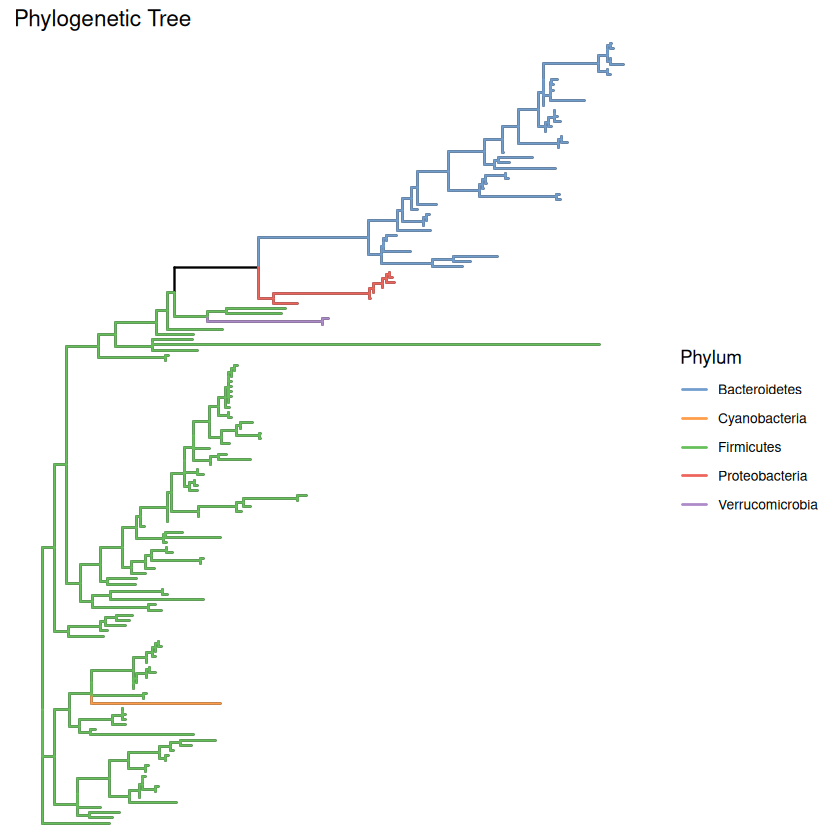

In [7]:
data("Tengeler2020", package = "mia")
tse <- Tengeler2020

p <- plotRowTree(
    tse,
    layout = "rectangular",
    edge_colour_by = "Phylum"
)

p + ggtitle("Phylogenetic Tree")

In [ ]:
# sonify()